## Istruzioni per l'analisi dati con modelli di machine learning

##### Primi step:
- Leggere la descrizione del progetto
- Scaricare i dati e metterli in una cartella `data`: https://www.dropbox.com/scl/fi/bk937nxb072s8nwsmeac1/fastcluster_comp_physA.tgz?rlkey=f5uexpccuj3eocvafdxurjb4m&dl=1 (nel caso lo trovate anche all'interno della descrizione del progetto)
- Leggere il paper della Mapelli: https://arxiv.org/abs/2103.05016

### Idea di analisi

L'idea è di splittare l'analisi in due parti:

- In base alle features (colonne) dei vari sistemi di binary BHs, capire a quale "oggetto ospitante" appartengono questi sistemi. 
  Quindi si tratta di un problema di classificazione con label la colonna `label` del dataset che corrisponde a `0 -> GC, 1 -> nSC, 2 -> ySC`. L'analisi della feature importance ci dirà quali sono le features più importanti per capire quale sistema appartiene a quale oggetto.

- Analizzare ogni "oggetto ospitante" indipendentemente (bisogna filtrare rispetto alla colonna `label`). Per fare ciò ho aggiunto un'altra colonna di label `label_ngen`: `0` se il sistema non ha altri merger oltre la 2a generazione; `1` se il sistema evolve oltre la 2a generazione.
  Si tratta sempre di un problema di classificazione, questa volta rispetto a `label_ngen`. L'analisi delle features importance ci dirà quali sono le features più importanti che portano i sistema a evolvere e quali no.

- Per fare ciò in una maniera più dettagliata, sia a livello globale (tutte le label insieme) che a livello locale (singola label), useremo gli `SHAP` values (in fondo a questo file c'è una descrizione riguardo questi valori).

### Plots

- Martina sta ultimando i plot "descrittivi" del dataset, che dovremo descrivere per dare una prima analisi "by eye" di come le features sono distribuite nel dataset e vedere se c'è qualche correlazione rispetto alle label.

### Modelli

Per facilitare il lavoro e avere un notebook pulito ho creato un file con diverse funzioni che serviranno per la creazione del dataset, per il training dei modelli e per il plot relativi ai modelli. Il file è `hmbh.py` e si trova nella stessa repo/branch di questo file di istruzioni.
Per poterlo usare salvatelo nella stessa cartella in cui salverete il vostro notebook. Per usare il modulo ad hoc:
```python
import hmbh as h
```

Le funzioni sono dotate di documentazione per capire per sommi capi a cosa servono e che input necessitano. Per una documentazione più approfondita, rispetto a funzioni e metodi utilizzati all'interno di esse, guardate la documentazione ufficiale.

*Se non vi piace usare le funzione e volete fare altro rispetto a quello che ho scritto, fate pure.*

Oltre all'analisi divisa in due parti, traineremo due modelli separati, sempre tree-based ma con concept diversi. Vedremo che i risultati saranno praticamente gli stessi: 
- `RandomForestClassifier`
- `XGBoostClassifier`

Ogni modello verrà prima trainato in una versione base e poi si farà un GridSearch per trovare la migliore combinazione di hyperparameter. Anche qui per vedere che differenze di performance si hanno.

Una volta trainati i modelli `RF_best` e `XGB_best` (quelli con il GridSearch), si useranno questi per calcolare gli `SHAP` values e descrivere i risultati.

Prima di procedere con l'analisi vera e propria si può fare uno step preliminare: andare a vedere che percentuale del dataset serve per avere dei risultati soddisfacenti a livello di training e test (spoiler non servono tutti i 3 mln di sample). 
Per questo esiste una funzione che si chiama `plot_learning_score`. Come funziona? Si costruisce il modello base di RF o XGB e lo si passa alla funzione con tutto il dataset. Questa plotterà gli score di training e test. SI vedrà che dopo un certo numero di sample la curva di test si assesterà. Prendere il valore sull'asse X prima della stabilizzazione e ridurre il numero di sample con `pd.sample`. Ripetere l'analisi con la prima funzione e fermarsi quando si ritiene che non ci sia più uno stabilizzarsi degli score. 

Usare questo numero finale per creare il dataset di trining e test con la funzione `data_preprocessing`. Da qui si possono usare i dataset appena creati per trainare i due modelli.

La funzione `data_preprocessing`, permette di bilanciare il numero di label. Se fate delle prove vedrete che quando il dataset è grande e quindi ci sono molte label per `y=2` i modelli non faticano a predirla. Se si riduce il dataset il numero di label per `y=2` diminuisce e quindi i modelli falliscono nel classificare correttamente i sistemi. Per questo sarà prime necessario bilanciare le label.

##### Creazione dataset
```python

path = '../data/'

folder = ['GC_chi01_output_noclusterevolv', 'NSC_chi01_output_noclusterevolv',
               'YSC_chi01_output_noclusterevolv']
    
metallicity = ['0.0002', '0.002', '0.02', '0.0004', '0.004', '0.006', '0.0008',
                   '0.008', '0.0012', '0.012', '0.0016', '0.016']

cols = ['c0', 'c1', 'c2', 'c3', 'c4', 'c7', 'c8', 'c9', 'c13', 'c15', 'c16', 'c17', 'c25', 'c27'] # select bold columns -> most important for this analysis

new_cols = ['ID', 'bh_mass1', 'bh_mass2', 'spin1', 'spin2', 'semimajor', 'i_ecc', 'time_dyn', 'time_merge', 
'remnant_mass', 'remnant_spin', 'escape_vel', 'cluster_mass', 'n_gen']

df = h.create_dataset(path, folder, metallicity, cols)

df = h.rename_columns(df, new_cols)

df = h.get_label_ngen(df)

```

##### Data preprocessing 

```python 

X, y, X_train, y_train, X_test, y_test = data_preprocessing(df, n_sample=None, label='label', test_size=0.2, balanced_label=False)

sample_RF = RandomForestClassifier(n_estimators=10, class_weight='balanced_subsample', criterion='entropy', random_state=random_state)

plot_learning_curve(sample_RF, 'Test_RF', X, y, cv=2, train_sizes=np.linspace(0.1, 1.0, 5), n_jobs=4)

```

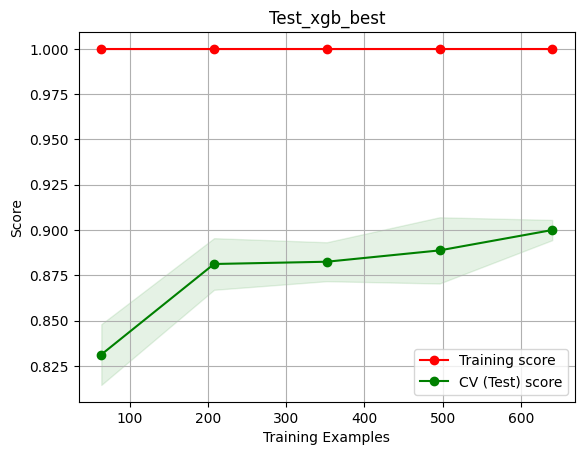

In questo esempio si può vedere che attorno ai 350 sample lo score si stabilizza, quindi si può procedere in questo modo.

```python

X = X.sample(n=350, random_state=42)
y = y.sample(n=350, random_state=42)
# la funzione `df.sample` fa uno shuffle dei dati

plot_learning_curve(sample_RF, 'Test_RF', X, y, cv=2, train_sizes=np.linspace(0.1, 1.0, 5), n_jobs=4)

```

Da ripetere fino a quando si pensa che si abbia trovato il valore "corretto"

Quindi procedere a creare il dataset vero e proprio

```python

numero_migliore = 

X, y, X_train, y_train, X_test, y_test = data_preprocessing(df, n_sample=numero_migliore, label='label', test_size=0.2, balanced_label=False)

```

Qui potete fare una semplice prova con `simple_RF` cambiando la flag di `balanced_label`. Dalla confusion matrix capirete che è meglio tenere le label bilanciate.

##### Training dei modelli 

```python

RF, y_pred = simple_RF(X_train, y_train, X_test)

model_evaluation(RF, X, y, X_train, y_train, X_test, y_test, y_pred)

```

`model_evaluation` vi printerà la confusion matrix e un primo plot di features importance, direttamente dal pacchetto di `sklearn`. Questo plot lo si potrà confrontare con quello degli `SHAP`.

```python

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 300, 500, 800],
    'max_depth': [5, 15, 25, 50],
    'min_samples_split': [5, 10, 15, 20, 30, 40 , 50, 60, 70, 80]
}

# se vi suole si può ricreare il dataset con `data_preprocessing`

RF_best, y_pred, grid_search = gridsearch_RF(param_grid=param_grid, cv=3, X_train=X_train, y_train=y_train, X_test=X_test, n_jobs=4)

gridsearch_scores(grid_search=grid_search)

model_evaluation(RF_best, X, y, X_train, y_train, X_test, y_test, y_pred)

```

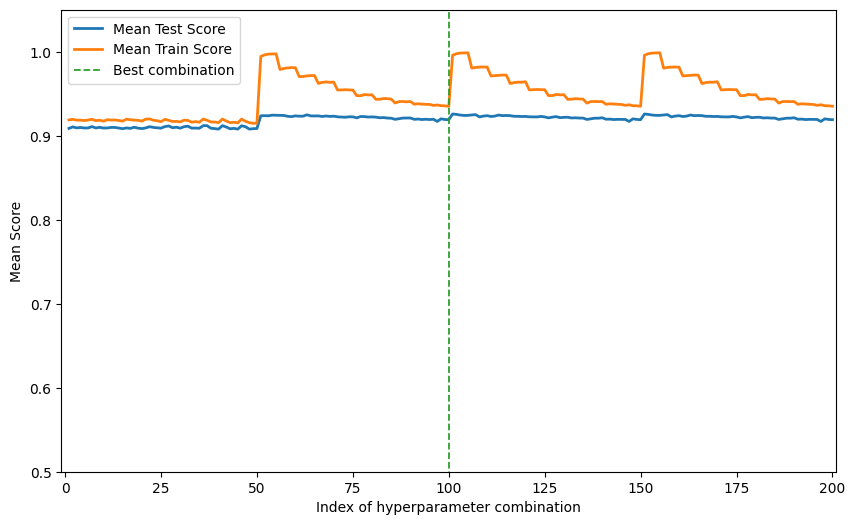

La funzione `gridsearch_score` plotterà il valore medio del train e test score delle varie combinazioni di hyperparameters e in versi la migliore combinazione.

Ripetere le operazioni svolte con la RF anche per XGBoost utilizzando le funzioni corrispondenti. 
Il gridsearch di XGBoost potrebbe metterci molto e consumare molta ram. Quindi nel caso provaste e il computer non ce la faceste, ditemelo che lo runno io. 

```python

param_grid = {
    'n_estimators': [50, 100, 300, 500, 800],    # Number of boosting rounds
    'max_depth': [5, 15, 25, 50],                # Maximum depth of each tree
    'learning_rate': [0.01, 0.1, 0.2],           # Learning rate (shrinkage parameter)
    'subsample': [0.5, 0.8],                # Fraction of samples used for training each tree
    'colsample_bytree': [0.3, 0.5],         # Fraction of features used for training each tree
    'gamma': [0, 0.1, 0.2],                      # Minimum loss reduction required to make a further partition on a leaf node
    #'reg_alpha': [0, 0.1, 0.2],                  # L1 regularization term on weights
    'reg_lambda': [0, 0.1, 0.2],                 # L2 regularization term on weights
    #'min_child_weight': [1, 3, 5],               # Minimum sum of instance weight needed in a child
}
```

Questo è un esempio di grid. Fate le vostre ricerche e capite quali solo gli hyperparametri su cui è meglio lavorare. Ovviamente più parametri di mettono e maggiore sarà il carico computazionale. 

Ho preferito fare un gridsearch unico e non parametro per parametro, perché è vero che computazionalmente è costoso (ma non è un problema perché lo posso far runnare in parallelo su diversi core), ma dà i migliori risultati. (ma vedrete che già i modelli base sono più che ottimi) 

### SHAP Values

*Questa è la descrizione presa da un progetto precedente. Se la volete corredata di esempio per capire che cosa significano i plot, potete guardare: https://github.com/Berto70/bse_bhms/blob/main/bse_bhms_classification.ipynb (o la presentazione PDF nella stessa repo).* 

------------------

[SHAP](https://shap.readthedocs.io/en/latest/) (SHapley Additive exPlanations) values are a method used to explain the predictions of machine learning models. They were introduced by [Lundberg and Lee](https://papers.nips.cc/paper_files/paper/2017/file/8a20a8621978632d76c43dfd28b67767-Paper.pdf) in 2017 and are based on cooperative game theory.

SHAP values provide a way to allocate the contribution of each feature in a prediction model to the final prediction. They aim to quantify the impact of each feature on the prediction outcome by considering all possible combinations of features and calculating the contribution of each feature in each combination.

The core idea behind SHAP values is the concept of [Shapley values](https://en.wikipedia.org/wiki/Shapley_value), which is a method for fairly distributing the payout of a cooperative game among the players based on their individual contributions. In the context of machine learning models, the features are treated as players, and the prediction outcome is the payout.

To calculate SHAP values, a baseline reference is established, which serves as a starting point for the feature contributions. Then, different combinations of features are created, and for each combination, the model predictions are observed. The contribution of each feature is determined by comparing the predictions with and without the feature included.

SHAP values provide several advantages in interpreting machine learning models. They offer a unified framework for feature importance measurement that is both consistent and locally accurate. They also satisfy desirable properties such as consistency, meaning that if a feature is removed or added, the SHAP values change accordingly. Furthermore, SHAP values can be used to explain individual predictions as well as provide an overview of feature importance across the entire dataset.

In our study, we employed three types of visualizations to gain insights into the importance of each feature*.

Summary plot (bar type) for global inspection
This kind of plot examine the mean absolute SHAP value for each feature across all of the data. This quantifies, on average, the magnitude of each feature's contribution towards the predicted label. If a feature has a high mean SHAP value, it suggests that it generally has a strong influence on the predictions. Conversely, a low mean SHAP value indicates that the feature has less impact on the model's predictions. Mean absolute SHAP values are essentially a drop-in replacement for more traditional feature importance measures but have two key advantages:

Mean absolute SHAP values are more theoretically rigorous, and relate to which features impact predictions most. Conventional feature importances are measured in more abstract and algorithm-specific ways, and are determined by how much each feature improves the model's predictive performance.
Mean absolute SHAP values have intuitive units, like the target variable. Feature importances are often expressed in counterintuitive units based on complex concepts such as tree algorithm node impurities.
The features are presented in descending order of importance, with the most significant feature listed at the top and the less significant features listed towards the bottom.

Summary plot (bar type) for labels inspection
We created separate plots for each label to gain a more accurate understanding of the feature importance. By examining the importance of features for each label individually, we obtained specific insights into their contributions to the prediction accuracy for each class.

Summary plot (violin type) for each label (evolution channel)
This is the most useful type of plot for our study. A SHAP violin plot provides a visual representation of the distribution of SHAP values for different features in the model. It helps in understanding the impact of each feature on the model's predictions.

Vertical Axis: The vertical axis represents the features in the model. The features are presented in descending order of importance.

Horizontal Axis: The horizontal axis represents the range of SHAP values. It spans from negative to positive values, indicating the direction and magnitude of the feature's influence on the predictions.

Violin Shape: Each violin-shaped distribution represents the density of the SHAP values for a specific feature. The width of the violin at a given point represents the density or frequency of SHAP values at that point.

A wider section of the violin indicates a higher density of SHAP values, indicating a stronger influence of the feature on the predictions.
A narrower section of the violin indicates a lower density of SHAP values, suggesting a weaker influence.
Original value: Color shows whether that variable is high (in red) or low (in blue) for that observation.

The SHAP violin plot allows you to compare the distributions of SHAP values across different features. It helps identify features that have consistent and impactful contributions (wider violins with higher densities) and those that have less influence (narrower violins with lower densities).

The plot can also reveal features with bimodal or asymmetric distributions, indicating the presence of different subgroups or distinct patterns in the data that affect the predictions differently.

* ref1: https://www.aidancooper.co.uk/a-non-technical-guide-to-interpreting-shap-analyses/
* ref2: https://medium.com/dataman-in-ai/explain-your-model-with-the-shap-values-bc36aac4de3d

Dopo che si è trainato il modello `RF_best`/`XGB_best`, con i corrispettivi test set, si può procedere con gli `SHAP` values

```python

shap_values_RF = shap_explainer(RF_best, X_test, n_sample=1000)

plot_shap_violin(shap_values_RF, X_test, n_sample=1000)

plot_shap_bar(shap_values_RF)

```

Il modello da usare è il best (potremmo fare un'analisi per i 4 modelli ma i risultati sono li stessi quindi stica). Il set da usare (nell'esempio quello di test) è il set su cui vogliamo avere una spiegazione dei risultati. Può essere il set totale, può essere quello di test o quello di training. 
Io proverei, una volta che si ha il modello trainato, a usare sia `X` che `X_test`. Per vedere se si nota qualche differenza (dubito, perché il modello ha un'accuracy molto elevata). 
Il numero di sample `n_sample` è una parte critica a livello computazionale. Per fortuna non stiamo lavorando con NN, quindi ci va anche bene. 
Provate a fare un test con `n_sample=None` (quindi usando tutto il vostro dataset che avete scelto `X`/`X_test`). Vedete quanto ci mette. Se ci mette troppo, riducete a 3/4 il numero di sample `X.shape[0]*0.75` e vedete come va. Se ci mette ancora troppo dimezzate o passate direttamente a 1000. Tanto i risultati saranno pressoché simili sempre per il fatto che entrambi i modelli generalizzano bene.

Di tutto cercate di commentare i risultati in modo completo e puntuale, cosicché possiamo inserire i commenti nel notebook finale. Potete lasciare i commenti agli shap values. quelli li posso fare io.

Grazie 💚💚